In [99]:
!pip install tqdm

     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ---------------------------------------- 57.6/57.6 kB 1.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/78.3 kB ? eta -:--:--
   ---------------------------------------- 78.3/78.3 kB 4.3 MB/s eta 0:00:00


In [76]:
import os 
import numpy as np
from torch.utils.data import Dataset , DataLoader , Subset
import glob
import tqdm
from tqdm import tqdm_notebook
import PIL
import copy
from torchvision import models
from torch import nn
from PIL import Image
import random
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_pil_image
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
import torch
from sklearn.model_selection import StratifiedShuffleSplit

In [35]:
path2ajpgs = "HMD51_Data_jpg"

In [36]:
def get_vids(path2ajpgs):
    listOfCats = os.listdir(path2ajpgs)
    ids = []
    labels = []
    for catg in listOfCats:
        path2catg = os.path.join(path2ajpgs, catg)
        listOfSubCats = os.listdir(path2catg)
        path2subCats= [os.path.join(path2catg,los) for los in listOfSubCats]
        ids.extend(path2subCats)
        labels.extend([catg]*len(listOfSubCats))
    return ids, labels, listOfCats 

In [37]:
all_vids, all_labels, catgs = get_vids(path2ajpgs)
len(all_vids), len(all_labels), len(catgs)

(6766, 6766, 51)

In [38]:
labels_dict = {}
ind = 0
for uc in catgs:
    labels_dict[uc] = ind
    ind+=1
labels_dict

{'brush_hair': 0,
 'cartwheel': 1,
 'catch': 2,
 'chew': 3,
 'clap': 4,
 'climb': 5,
 'climb_stairs': 6,
 'dive': 7,
 'draw_sword': 8,
 'dribble': 9,
 'drink': 10,
 'eat': 11,
 'fall_floor': 12,
 'fencing': 13,
 'flic_flac': 14,
 'golf': 15,
 'handstand': 16,
 'hit': 17,
 'hug': 18,
 'jump': 19,
 'kick': 20,
 'kick_ball': 21,
 'kiss': 22,
 'laugh': 23,
 'pick': 24,
 'pour': 25,
 'pullup': 26,
 'punch': 27,
 'push': 28,
 'pushup': 29,
 'ride_bike': 30,
 'ride_horse': 31,
 'run': 32,
 'shake_hands': 33,
 'shoot_ball': 34,
 'shoot_bow': 35,
 'shoot_gun': 36,
 'sit': 37,
 'situp': 38,
 'smile': 39,
 'smoke': 40,
 'somersault': 41,
 'stand': 42,
 'swing_baseball': 43,
 'sword': 44,
 'sword_exercise': 45,
 'talk': 46,
 'throw': 47,
 'turn': 48,
 'walk': 49,
 'wave': 50}

## **Selecting 5 classes**

In [39]:
num_classes = 5
unique_ids = [id_ for id_, label in zip(all_vids,all_labels) if labels_dict[label]<num_classes]
unique_labels = [label for id_, label in zip(all_vids,all_labels) if labels_dict[label]<num_classes]
len(unique_ids),len(unique_labels)

(555, 555)

In [40]:
 sss = StratifiedShuffleSplit(n_splits=2, test_size=0.1, random_state=0)
train_indx, test_indx = next(sss.split(unique_ids, unique_labels))

In [41]:
train_indx

array([ 53, 336,  35, 515, 354,  79, 488, 337, 311, 522, 519,  10, 474,
       330, 173, 204, 186, 443,  25, 407,  48, 212, 467, 195, 509, 166,
        85, 473, 318, 470, 387, 360, 527,  37, 554, 417, 497, 167, 176,
       252,  29, 331, 380,  76,  52, 272, 285, 480, 328, 324, 416, 513,
       223, 129, 111,  38, 477, 396, 448, 359, 303,  42,  94, 463,   3,
       279, 469, 202,  56, 297,  34, 475, 353, 124, 369, 476, 242, 433,
       408, 104, 451, 216,  33, 393, 439, 262, 291, 368, 505,  46, 551,
       159, 248, 152, 289, 187, 483, 153, 298, 460, 322, 487,  75, 457,
       307, 537, 414, 462, 357, 543, 240,  66, 532, 319, 265, 429, 139,
       544, 171, 225, 503,  91, 524,   1, 210, 234, 496,  71, 363,  97,
       116, 238, 424, 389, 465,  31, 385,  13, 132,  95,   6, 510, 258,
       221, 395,  50, 399, 274, 119, 478,  24, 531, 172, 263, 280, 136,
       459, 371, 418,  16, 185,  54, 193, 314, 339, 504, 286, 271, 428,
       409, 194, 471,  98, 100, 276,  78, 438,  22, 550, 521, 42

In [42]:
train_ids = [unique_ids[ind] for ind in train_indx]
train_labels = [unique_labels[ind] for ind in train_indx]
print(len(train_ids), len(train_labels))
test_ids = [unique_ids[ind] for ind in test_indx]
test_labels = [unique_labels[ind] for ind in test_indx]
print(len(test_ids), len(test_labels))

499 499
56 56


In [43]:
class VideoDataset(Dataset):
    def __init__(self, ids, labels, transform):      
        self.transform = transform
        self.ids = ids
        self.labels = labels
    def __len__(self):
        return len(self.ids)
    def __getitem__(self, idx):
        path2imgs=glob.glob(self.ids[idx]+"/*.jpg")
        path2imgs = path2imgs[:timesteps]
        label = labels_dict[self.labels[idx]]
        frames = []
        for p2i in path2imgs:
            frame = Image.open(p2i)
            frames.append(frame)
        
        seed = np.random.randint(1e9)        
        frames_tr = []
        for frame in frames:
            random.seed(seed)
            np.random.seed(seed)
            frame = self.transform(frame)
            frames_tr.append(frame)
        if len(frames_tr)>0:
            frames_tr = torch.stack(frames_tr)
        return frames_tr, label

In [44]:
model_type = "3dcnn"
timesteps =16
if model_type == "rnn":
    h, w =224, 224
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
else:
    h, w = 112, 112
    mean = [0.43216, 0.394666, 0.37645]
    std = [0.22803, 0.22145, 0.216989]

In [45]:

train_transformer = transforms.Compose([
            transforms.Resize((h,w)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomAffine(degrees=0,
                                    translate=(0.1,0.1)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
            ])

In [46]:
train_ds = VideoDataset(ids= train_ids, labels= train_labels, transform= train_transformer)
print(len(train_ds))

499


In [47]:
train_ds

In [48]:
imgs, label = train_ds[random.choice(range(596))]
if len(imgs)>0:
    print(imgs.shape, label, torch.min(imgs), torch.max(imgs))

torch.Size([16, 3, 112, 112]) 3 tensor(-1.8952) tensor(2.4730)


In [49]:
imgs[1]

tensor([[[-1.8952, -1.8952, -1.8952,  ...,  2.4042,  2.4042,  2.4042],
         [-1.8952, -1.8952, -1.8952,  ...,  2.4042,  2.4042,  2.4042],
         [-1.8952, -1.8952, -1.8952,  ...,  2.4042,  2.4042,  2.4042],
         ...,
         [-1.8952, -1.8952, -1.8952,  ..., -1.8952, -1.8952, -1.8952],
         [-1.8952, -1.8952, -1.8952,  ..., -1.8952, -1.8952, -1.8952],
         [-1.8952, -1.8952, -1.8952,  ..., -1.8952, -1.8952, -1.8952]],

        [[-1.7822, -1.7822, -1.7822,  ...,  0.0418,  0.0418,  0.0418],
         [-1.7822, -1.7822, -1.7822,  ...,  0.0418,  0.0418,  0.0418],
         [-1.7822, -1.7822, -1.7822,  ...,  0.0418,  0.0418,  0.0418],
         ...,
         [-1.7822, -1.7822, -1.7822,  ..., -1.7822, -1.7822, -1.7822],
         [-1.7822, -1.7822, -1.7822,  ..., -1.7822, -1.7822, -1.7822],
         [-1.7822, -1.7822, -1.7822,  ..., -1.7822, -1.7822, -1.7822]],

        [[-1.7349, -1.7349, -1.7349,  ...,  1.4098,  1.4098,  1.4098],
         [-1.7349, -1.7349, -1.7349,  ...,  1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


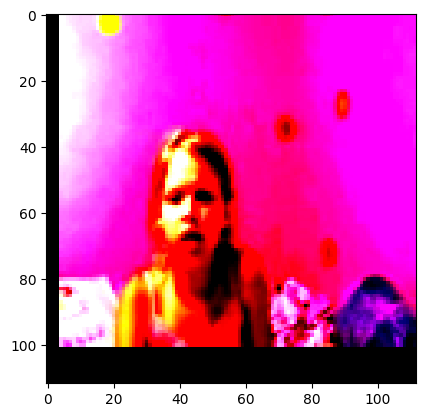

In [50]:
plt.imshow(imgs[1].permute(1, 2 ,0))

In [51]:
def denormalize(x_, mean, std):
    x = x_.clone()
    for i in range(3):
        x[i] = x[i]*std[i]+mean[i]
    x = to_pil_image(x)        
    return x

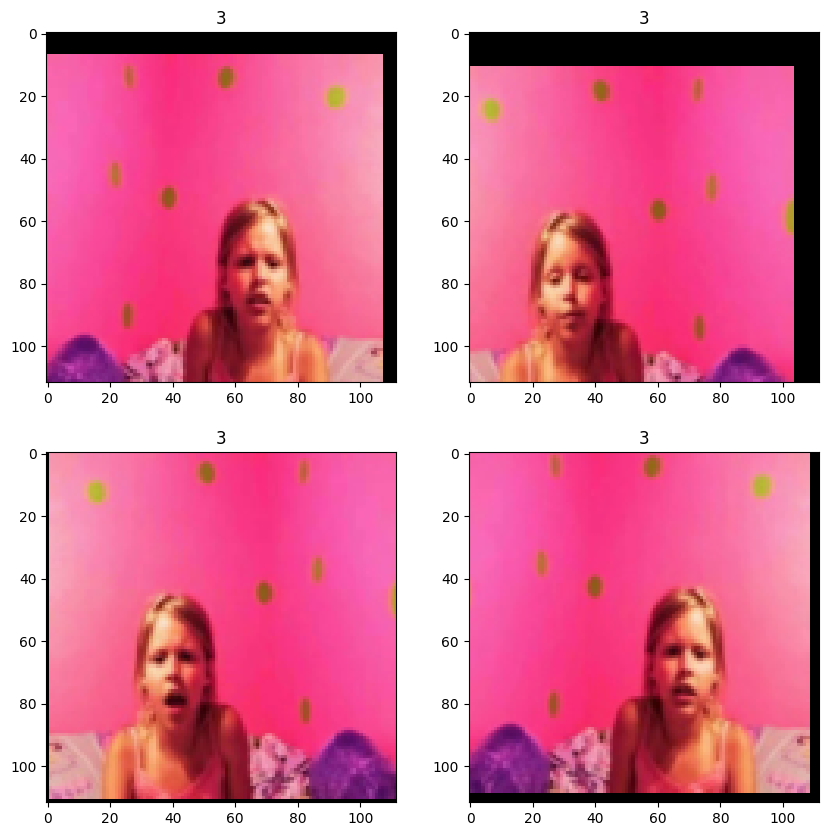

In [52]:
 plt.figure(figsize=(10,10))
 for ii,img in enumerate(imgs[::4]):
    plt.subplot(2,2,ii+1)
    plt.imshow(denormalize(img, mean, std))
    plt.title(label)

In [53]:
 test_transformer = transforms.Compose([
            transforms.Resize((h,w)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
            ])

In [54]:
test_ds = VideoDataset(ids= test_ids, labels= test_labels,
transform= test_transformer)
print(len(test_ds))

56


In [55]:
imgs, label = test_ds[random.choice(range(67))]
imgs.shape, label, torch.min(imgs), torch.max(imgs)

(torch.Size([16, 3, 112, 112]), 4, tensor(-1.8952), tensor(2.6748))

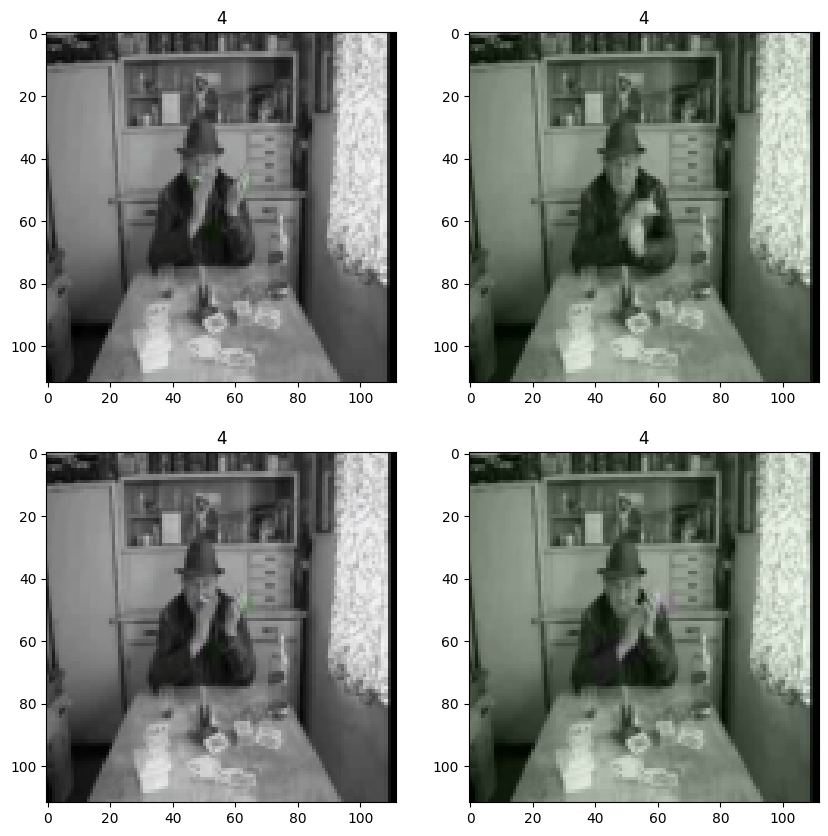

In [56]:
plt.figure(figsize=(10,10))
for ii,img in enumerate(imgs[::4]):
    plt.subplot(2,2,ii+1)
    plt.imshow(denormalize(img, mean, std))
    plt.title(label)

In [57]:
def collate_fn_r3d_18(batch):
    imgs_batch, label_batch = list(zip(*batch))
    imgs_batch = [imgs for imgs in imgs_batch if len(imgs)>0]
    label_batch = [torch.tensor(l) for l, imgs in zip(label_batch, imgs_batch) if len(imgs)>0]
    imgs_tensor = torch.stack(imgs_batch)
    imgs_tensor = torch.transpose(imgs_tensor, 2, 1)
    labels_tensor = torch.stack(label_batch)
    return imgs_tensor,labels_tensor

def collate_fn_rnn(batch):
    imgs_batch, label_batch = list(zip(*batch))
    imgs_batch = [imgs for imgs in imgs_batch if len(imgs)>0]
    label_batch = [torch.tensor(l) for l, imgs in zip(label_batch, imgs_batch) if len(imgs)>0]
    imgs_tensor = torch.stack(imgs_batch)
    labels_tensor = torch.stack(label_batch)
    return imgs_tensor,labels_tensor
    

batch_size = 1
if model_type == "rnn":
    train_dl = DataLoader(train_ds, batch_size= batch_size,
                          shuffle=True, collate_fn= collate_fn_rnn)
    test_dl = DataLoader(test_ds, batch_size= 2*batch_size,
                         shuffle=False, collate_fn= collate_fn_rnn)  
else:
    train_dl = DataLoader(train_ds, batch_size= batch_size, 
                          shuffle=True, collate_fn= collate_fn_r3d_18)
    test_dl = DataLoader(test_ds, batch_size= 2*batch_size, 
                         shuffle=False, collate_fn= collate_fn_r3d_18)

In [58]:
# train_dl = DataLoader(train_ds, batch_size= batch_size, shuffle=True, collate_fn = collate_fn_r3d_18)
# test_dl = DataLoader(test_ds, batch_size= 2*batch_size, shuffle=False, collate_fn= collate_fn_r3d_18)

In [59]:
for xb,yb in train_dl:
    print(xb.shape, yb.shape)
    break
for xb,yb in test_dl:
    print(xb.shape, yb.shape)
    break

torch.Size([1, 3, 16, 112, 112]) torch.Size([1])
torch.Size([2, 3, 16, 112, 112]) torch.Size([2])


In [60]:
from torch import nn
class Resnt18Rnn(nn.Module):
    def __init__(self, params_model):
        super(Resnt18Rnn, self).__init__()
        num_classes = params_model["num_classes"]
        dr_rate= params_model["dr_rate"]
        pretrained = params_model["pretrained"]
        rnn_hidden_size = params_model["rnn_hidden_size"]
        rnn_num_layers = params_model["rnn_num_layers"]
        
        baseModel = models.resnet18(pretrained=pretrained)
        num_features = baseModel.fc.in_features
        baseModel.fc = Identity()
        self.baseModel = baseModel
        self.dropout= nn.Dropout(dr_rate)
        self.rnn = nn.LSTM(num_features, rnn_hidden_size, rnn_num_layers)
        self.fc1 = nn.Linear(rnn_hidden_size, num_classes)
    def forward(self, x):
        b_z, ts, c, h, w = x.shape
        ii = 0
        y = self.baseModel((x[:,ii]))
        output, (hn, cn) = self.rnn(y.unsqueeze(1))
        for ii in range(1, ts):
            y = self.baseModel((x[:,ii]))
            out, (hn, cn) = self.rnn(y.unsqueeze(1), (hn, cn))
        out = self.dropout(out[:,-1])
        out = self.fc1(out) 
        return out 
    
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x    

In [61]:
if model_type == "rnn":
    params_model={
        "num_classes": num_classes,
        "dr_rate": 0.1,
        "pretrained" : True,
        "rnn_num_layers": 1,
        "rnn_hidden_size": 100,}
    model = Resnt18Rnn(params_model)        
else:
    model = models.video.r3d_18(weights=True, progress=False)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)

P:\conda\env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [71]:
model

VideoResNet(
  (stem): BasicStem(
    (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1):

In [79]:
def train_val(model, params):
    num_epochs=params["num_epochs"]
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]
    
    loss_history={
        "train": [],
        "val": [],
    }
    
    metric_history={
        "train": [],
        "val": [],
    }
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss=float('inf')
    
    for epoch in range(num_epochs):
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))
        model.train()
        train_loss, train_metric=loss_epoch(model,loss_func,train_dl,sanity_check,opt)
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(model,loss_func,val_dl,sanity_check)
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")
        
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print("Loading best model weights!")
            model.load_state_dict(best_model_wts)
        
        print("-"*10) 
    model.load_state_dict(best_model_wts)
        
    return model, loss_history, metric_history

 
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

def metrics_batch(output, target):
    pred = output.argmax(dim=1, keepdim=True)
    corrects=pred.eq(target.view_as(pred)).sum().item()
    return corrects

def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target)
    with torch.no_grad():
        metric_b = metrics_batch(output,target)
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
    return loss.item(), metric_b
    

def loss_epoch(model,loss_func,dataset_dl,sanity_check=False,opt=None):
    running_loss=0.0
    running_metric=0.0
    len_data = len(dataset_dl.dataset)
    for xb, yb in tqdm.notebook.tqdm(dataset_dl):
        xb=xb.to(device)
        yb=yb.to(device)
        output=model(xb)
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt)
        running_loss+=loss_b
        
        if metric_b is not None:
            running_metric+=metric_b
        if sanity_check is True:
            break
    loss=running_loss/float(len_data)
    metric=running_metric/float(len_data)
    return loss, metric


def plot_loss(loss_hist, metric_hist):

    num_epochs= len(loss_hist["train"])

    plt.title("Train-Val Loss")
    plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
    plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
    plt.ylabel("Loss")
    plt.xlabel("Training Epochs")
    plt.legend()
    plt.show()

    plt.title("Train-Val Accuracy")
    plt.plot(range(1,num_epochs+1), metric_hist["train"],label="train")
    plt.plot(range(1,num_epochs+1), metric_hist["val"],label="val")
    plt.ylabel("Accuracy")
    plt.xlabel("Training Epochs")
    plt.legend()
    plt.show()


In [80]:
device = "cpu"
path2weights = "models/weights.pt"
torch.save(model.state_dict(), path2weights)

In [81]:
loss_func = nn.CrossEntropyLoss(reduction="sum")
opt = optim.Adam(model.parameters(), lr=3e-5)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=5,verbose=1)
os.makedirs("./models", exist_ok=True)

params_train={
    "num_epochs": 20,
    "optimizer": opt,
    "loss_func": loss_func,
    "train_dl": train_dl,
    "val_dl": test_dl,
    "sanity_check": True,
    "lr_scheduler": lr_scheduler,
    "path2weights": "./models/weights_"+model_type+".pt",
    }
model,loss_hist,metric_hist = train_val(model,params_train)

Epoch 0/19, current lr=3e-05


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Copied best model weights!
----------
Epoch 1/19, current lr=3e-05


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

----------
Epoch 2/19, current lr=3e-05


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

----------
Epoch 3/19, current lr=3e-05


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

----------
Epoch 4/19, current lr=3e-05


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

----------
Epoch 5/19, current lr=3e-05


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

----------
Epoch 6/19, current lr=3e-05


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 00007: reducing learning rate of group 0 to 1.5000e-05.
Loading best model weights!
----------
Epoch 7/19, current lr=1.5e-05


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

----------
Epoch 8/19, current lr=1.5e-05


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

----------
Epoch 9/19, current lr=1.5e-05


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

----------
Epoch 10/19, current lr=1.5e-05


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

----------
Epoch 11/19, current lr=1.5e-05


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

----------
Epoch 12/19, current lr=1.5e-05


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 00013: reducing learning rate of group 0 to 7.5000e-06.
Loading best model weights!
----------
Epoch 13/19, current lr=7.5e-06


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

----------
Epoch 14/19, current lr=7.5e-06


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

----------
Epoch 15/19, current lr=7.5e-06


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

----------
Epoch 16/19, current lr=7.5e-06


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

----------
Epoch 17/19, current lr=7.5e-06


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

----------
Epoch 18/19, current lr=7.5e-06


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 00019: reducing learning rate of group 0 to 3.7500e-06.
Loading best model weights!
----------
Epoch 19/19, current lr=3.75e-06


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

----------
